# Gaussopt Example

- This example will walk through the basics of setting up a Gaussian telescope.
- Note: All distances are in mm and all frequencies are in GHz unless specified otherwise.

In [1]:
# Import the gaussopt package
from gaussopt import *

# Import modules for this notebook
import matplotlib.pyplot as plt 
%matplotlib inline
from IPython.display import Image

- Gaussian telescopes use two mirrors to couple energy between two horn antennas. If the mirrors have focal lengths $f$, then the mirrors should be separated by $2f$ and the distance between each horn's beam waist and it's respective mirror should be $f$.

![title](misc/GaussianBeamTelescope.jpg)

## Define frequency sweep

- The standard way to initialize this class is to define the start and end frequency. 
- This class assumes GHz unless a unit is provided.

In [2]:
freq = Frequency(150, 300, comment='rf sweep')

Frequency sweep: rf sweep
	f = 150.0 to 300.0 GHz, 301 pts



## Define horns

![title](misc/Horn.jpg)

In [3]:
slen = 22.64  # slant length (in mm)
arad = 3.6    # aperture radius (in mm)
hfac = 0.59   # horn factor
horn_tx = Horn(freq, slen, arad, hfac, comment='Trasmitting')
horn_rx = horn_tx.copy(comment='Receiving')

Horn: Trasmitting
	slen = 22.64 mm
	arad =  3.60 mm
	hf   =  0.59

Horn: Receiving
	slen = 22.64 mm
	arad =  3.60 mm
	hf   =  0.59



## Define optical components
- These classes will assume mm unless a unit is provided.

In [4]:
d = Freespace(160)
m1 = Mirror(16, units='cm', radius=8, comment='M1')
m2 = Mirror(16, units='cm', radius=8, comment='M2')

Freespace: 
	d = 160.0 mm

Mirror: M1
	f = 16.0 cm

Mirror: M2
	f = 16.0 cm



- Note that the distance between the horn and the mirror needs to be reduced because the actual beam waist will be behind the horn aperture.

In [5]:
z_offset = horn_tx.z_offset(units='mm')[freq.idx(230)]
d_red = Freespace(160 - z_offset, comment='reduced')

Freespace: reduced
	d = 155.8 mm



## Build Optical System

In [6]:
component_list = (d_red, m1, d, d, m2, d_red)

system = System(horn_tx, component_list, horn_rx)

System: 
[[-1.          0.00848684]
 [ 0.         -1.        ]]


## Plot Coupling

Best coupling: 100.0 % at 230.0 GHz


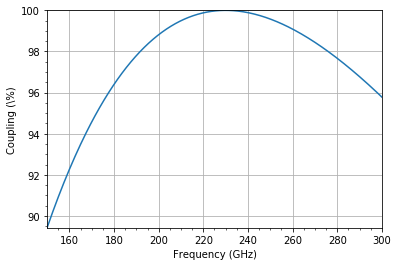

In [7]:
system.plot_coupling()
system.print_best_coupling()

## Plot Beam Propagation

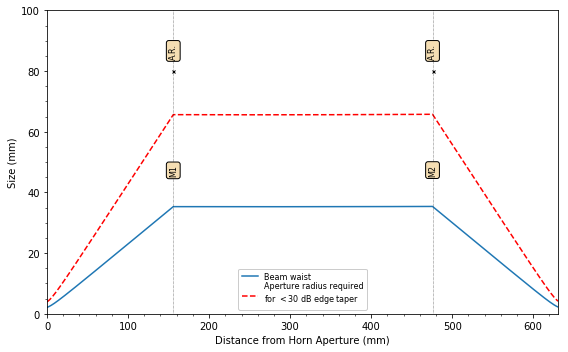

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
system.plot_system(ax=ax)